# Notebook to load examples from the test set over MVD dataset

### Imports and setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from os.path import isfile, join
from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset, MontevideoFoldersDataset_w_time, MontevideoFoldersDataset_w_CMV

#Deep Learning
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import random
from src.dl_models.unet import UNet, UNet2
from src.lib.latex_options import Colors, Linestyles

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = 'mvd'

time_horizon = 30

In [39]:
def show_seq_and_pred(sequence_array, time_list, prediction_t, fig_name=None, grid=True, day=None, model=None, savefig=False):
    """ Shows the images passed in a grid
    Args:
        sequence_array (array)
    """
    nbof_frames = sequence_array.shape[0]
    if np.max(sequence_array[0]) > 1.1:
        vmax = 100
    else:
        vmax = 1
    
    # plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    fontsize = 30 # 22 generates the font more like the latex text

    # plt.figure(figsize=(25, 5))
    fix = 2 if nbof_frames == 5 else 3
    fig, ax = plt.subplots(1, nbof_frames, figsize=(6 * nbof_frames - fix, 5)) # H,W of the whole fig

    
    for i in range(nbof_frames):
        if i < nbof_frames - 2:
            ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            input_nbr = i - (nbof_frames - 3)
            ax[i].set_title(f'{time_list[i]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid)


        if i == nbof_frames - 2:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            #cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'(GT) {time_list[-1]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid)

        if i == nbof_frames - 1:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            #cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'(Pred) {time_list[-1]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid)

        if nbof_frames == 6:
            line = plt.Line2D((.666, .666),(.03, 1), linewidth=3, color='gray', alpha=.5)
        elif nbof_frames == 5:
            line = plt.Line2D((.600, .600),(.03, 1), linewidth=3, color='gray', alpha=.5)
        else:
            line = plt.Line2D((.52, .52),(.1, 1), linewidth=3, color='gray', alpha=.5)
        fig.add_artist(line)

    if savefig:
        fig.tight_layout()
        time = time_list[-1].replace(':', '')
        # fig.savefig(f'reports/doc_images/{model}.png')
        fig.savefig(f'reports/doc_images/{model}_day{str(day)}_time{time}.png')
        
    plt.show()

### Models loading

In [4]:
# Unet ====================================================================
root_path = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/MVD/'

if time_horizon == 60:
    unet16 = '60min/60min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_15_17-02-2022_11:13_BEST_FINAL.pt'
elif time_horizon == 30:
    unet16 = '30min/30min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_34_16-02-2022_11:26_BEST_FINAL.pt'
else:
    unet16 = '90min/90min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_16_17-02-2022_06:27_BEST_FINAL.pt'
    
unet16_path = os.path.join(root_path, unet16)


OUTPUT_ACTIVATION = 'sigmoid'    

unet16 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
unet16.load_state_dict(torch.load(unet16_path, map_location=torch.device('cpu'))["model_state_dict"])
unet16.eval()

# wGAN ====================================================================
wgan64_path = f'/clusteruy/home/franco.mozo/deepCloud/checkpoints/GAN_FINAL_MODELS/wgan_64fil_20eps_ph{time_horizon}min.pt'

wgan_gen = UNet2(n_channels=3, n_classes=1, bilinear=True, bias=False, filters=64).to(device)
wgan_gen.load_state_dict(torch.load(wgan64_path, map_location=torch.device('cpu'))["model_state_dict"])
wgan_gen.eval()


# U-Net InputCMV
if time_horizon == 30:
    inputCMV_path = '30min/30min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_26_07-03-2022_23:21_BEST_FINAL.pt'
elif time_horizon == 60:
    inputCMV_path = '60min/60min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_20_06-03-2022_21:51_BEST_FINAL.pt'
else:
    inputCMV_path = '90min/90min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_18_06-03-2022_21:44_BEST_FINAL.pt'
inputCMV_path = os.path.join(root_path, inputCMV_path)

unet_inputCMV = UNet2(n_channels=4, n_classes=1, bilinear=True, p=0,
                      output_activation='sigmoid', bias=False, filters=16).to(device)
unet_inputCMV.load_state_dict(torch.load(inputCMV_path, map_location=torch.device('cpu'))["model_state_dict"])
unet_inputCMV.eval()

print('Done.')

Done.


In [5]:
#class to group two datasets
class MyDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [10]:
CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/test_cosangs_mvd.csv' # '/clusteruy/home03/DeepCloud/deepCloud/data/region3/test_cosangs_region3.csv'
normalize = preprocessing.normalize_pixels(mean0 = False) #values between [0,1]
FRAME_OUT = int(time_horizon/10)
OUTPUT_LAST = True

test_mvd = MontevideoFoldersDataset_w_time(
                path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',
                in_channel=3,
                out_channel=FRAME_OUT,
                min_time_diff=5,
                max_time_diff=15,
                csv_path=CSV_PATH,
                transform=normalize,
                output_last=OUTPUT_LAST
)

test_mvd_CMV = MontevideoFoldersDataset_w_CMV(
                                path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',  
                                cmv_path=f"/clusteruy/home03/DeepCloud/deepCloud/data/cmv/cmv_{dataset}_{time_horizon}min/test/",
                                in_channel=3, out_channel=FRAME_OUT,
                                min_time_diff=5, max_time_diff=15,
                                csv_path=CSV_PATH,
                                transform = normalize, output_last=OUTPUT_LAST,
                                day_pct=1)
  
test_mvd_datasets = MyDataset(test_mvd, test_mvd_CMV)
loader = DataLoader(test_mvd_datasets, batch_size=1, shuffle=True)
iterator = iter(loader)

##################
data_multiple_datasets = next(iterator)
_, _, in_time, out_time = data_multiple_datasets[0]

timestamp = out_time[0, 0]
day = int(in_time[0].numpy()[0,0]) 
t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
while day != 14 or t_6 != '16:20':
    data_multiple_datasets = next(iterator)
    _, _, in_time, out_time = data_multiple_datasets[0]

    timestamp = out_time[0, 0]
    day = int(in_time[0].numpy()[0,0]) 
    t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)    

Prediction horizon: 30
Day: 14
Model: U-Net


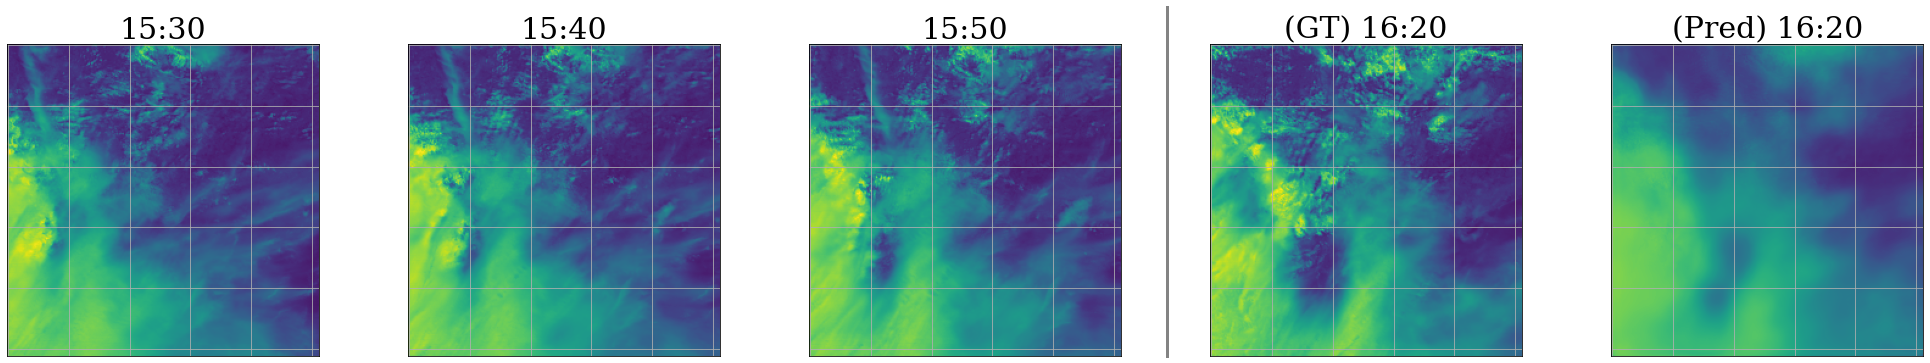

Model: wGAN


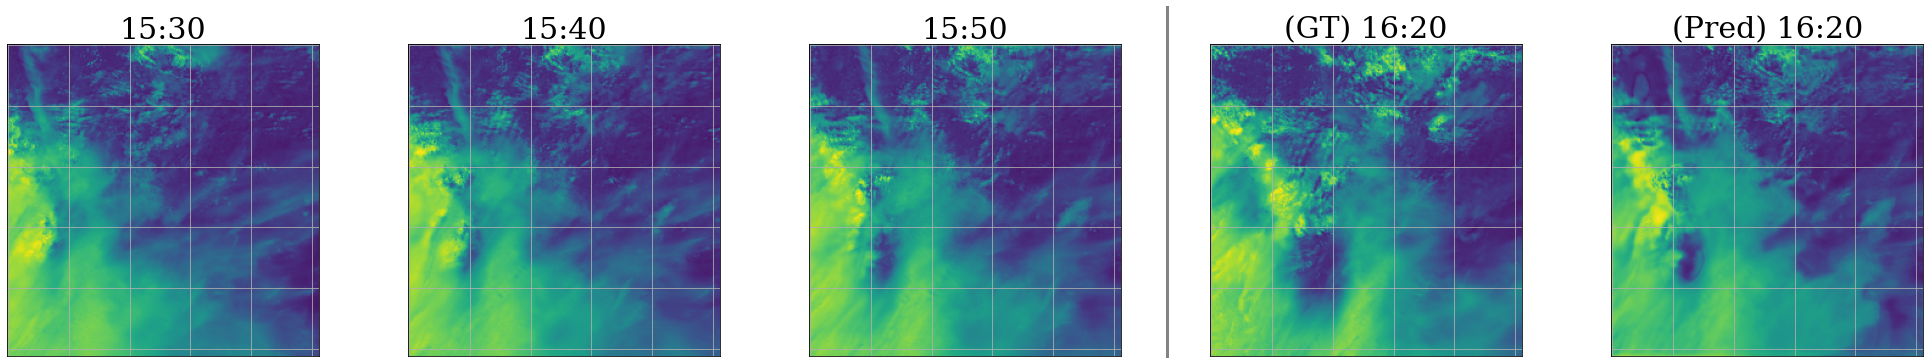

Model: U-Net InputCMV
(6, 256, 256)


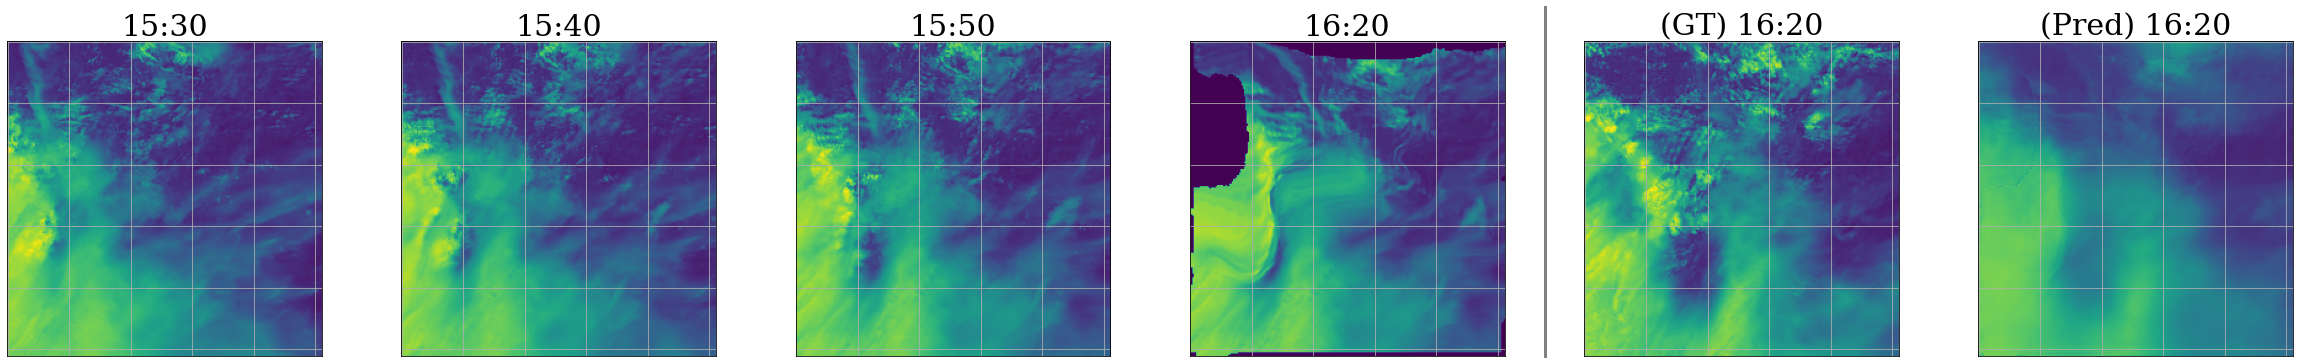

In [41]:
# data_multiple_datasets = next(iterator)
in_frames, out_frames, in_time, out_time = data_multiple_datasets[0]
# print(in_frames.shape, out_frames.shape)


in_frames_cmv, out_frames_cmv = data_multiple_datasets[1]
# print(in_frames_cmv.shape, out_frames_cmv.shape)
timestamp = out_time[0, 0]

with torch.no_grad():
    in_frames = in_frames.to(device=device)
    out_frames = out_frames.to(device=device)
    in_frames_cmv = in_frames_cmv.to(device=device)
    out_frames_cmv = out_frames_cmv.to(device=device)
    
    frames_pred_unet16 = unet16(in_frames)
    frames_pred_wgan_gen = wgan_gen(in_frames)
    frames_pred_inputCMV = unet_inputCMV(in_frames_cmv)

    
in_time = in_time[0].numpy()
print(f'Prediction horizon: {time_horizon}')
print('Day:', int(in_time[0,0]))

t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
t__2 = str(int((in_time[0][1]))).zfill(2) + ':' + str(int((in_time[0][2]))).zfill(2)
t__1 = str(int((in_time[1][1]))).zfill(2) + ':' + str(int((in_time[1][2]))).zfill(2)
t_0 = str(int((in_time[2][1]))).zfill(2) + ':' + str(int((in_time[2][2]))).zfill(2)

time_list = [t__2, t__1, t_0, t_6]

savefig = True

print(f'Model: U-Net')
sequence_array_60 = np.array([
            in_frames[0][0].cpu().numpy(),
            in_frames[0][1].cpu().numpy(),
            in_frames[0][2].cpu().numpy(),
            out_frames[0][0].cpu().numpy(),
            frames_pred_unet16[0, 0].cpu().numpy()
])
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True,
                  day=int(in_time[0,0]), 
                  model='U-Net',
                  savefig=savefig
                 )

print(f'Model: wGAN')
sequence_array_60 = np.array([
            in_frames[0][0].cpu().numpy(),
            in_frames[0][1].cpu().numpy(),
            in_frames[0][2].cpu().numpy(),
            out_frames[0][0].cpu().numpy(),
            frames_pred_wgan_gen[0, 0].cpu().numpy()
])
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True,
                  day=int(in_time[0,0]), 
                  model='wGAN',
                  savefig=savefig
                 )

print(f'Model: U-Net InputCMV')
sequence_array_60 = np.array([
            in_frames_cmv[0][0].cpu().numpy(),
            in_frames_cmv[0][1].cpu().numpy(),
            in_frames_cmv[0][2].cpu().numpy(),
            in_frames_cmv[0][3].cpu().numpy(),
            out_frames_cmv[0][0].cpu().numpy(),
            frames_pred_inputCMV[0, 0].cpu().numpy()
])
print(sequence_array_60.shape)
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True,
                  day=int(in_time[0,0]), 
                  model='U-Net_InputCMV',
                  savefig=savefig
                 )

### This part is to generate the error maps

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset_w_time
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from src.dl_models.unet import UNet, UNet2
from src.lib.latex_options import Colors, Linestyles
from src.lib.utils import get_model_name

# Modified script from evaluate_unet.py to generte error maps over MVD with gans and U-Net diff

### SETUP #####################################################################
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)
MSE = nn.MSELoss()
MAE = nn.L1Loss()
normalize = preprocessing.normalize_pixels(mean0 = False) #values between [0,1]
fontsize = 22 # 22 generates the font more like the latex text
borders = np.linspace(1, 450, 100)

###############################################################################

REGION = 'MVD'
dataset = 'mvd'


PREDICT_T_LIST = [3, 6, 9]
OUTPUT_ACTIVATION = 'sigmoid'    
FILTERS = 16
PREDICT_DIFF = False

# paths and names
UNET_BASE_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/'
UNET_NAMES = {
    3 : '30min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_34_16-02-2022_11:26_BEST_FINAL.pt',
    6 : '60min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_15_17-02-2022_11:13_BEST_FINAL.pt',
    9 : '90min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_16_17-02-2022_06:27_BEST_FINAL.pt'
}

evaluate_test = True
GENERATE_ERROR_MAP = True

if GENERATE_ERROR_MAP:
    RMSE_pct_maps_list = []
    RMSE_maps_list = []
    MAE_maps_list = []

for PREDICT_T in PREDICT_T_LIST:

    if PREDICT_T == 3:
        PREDICT_HORIZON = '30min'    
    if PREDICT_T == 6:
        PREDICT_HORIZON = '60min'
    if PREDICT_T == 9:
        PREDICT_HORIZON = '90min'

    print('Predict Horizon:', PREDICT_HORIZON)
    
    # MODEL_NAME = get_model_name(predict_horizon=PREDICT_HORIZON, architecture='UNET2', predict_diff=PREDICT_DIFF)
    # MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/' + PREDICT_HORIZON +  '/' + MODEL_NAME 
    
    model_name = UNET_NAMES[PREDICT_T]
    MODEL_PATH = os.path.join(UNET_BASE_PATH, REGION, PREDICT_HORIZON, model_name)
    
    model = UNet2(
        n_channels=3,
        n_classes=1,
        output_activation=OUTPUT_ACTIVATION,
        filters=FILTERS
    ).to(device)
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))["model_state_dict"])
    
    CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/test_cosangs_mvd.csv'
    PATH_DATA = '/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/'
    SAVE_IMAGES_PATH = 'graphs/' + REGION + '/' + PREDICT_HORIZON + '/test/' + MODEL_PATH.split('/')[-1][:-17]
    # SAVE_PER_HOUR_ERROR = 'reports/eval_per_hour/' + REGION + '/' + PREDICT_HORIZON + '/test'
    SAVE_BORDERS_ERROR = 'reports/borders_cut/' + REGION + '/' + PREDICT_HORIZON + '/test'

    try:
        os.mkdir(SAVE_IMAGES_PATH)
    except:
        pass

    #try:
    #    os.mkdir(SAVE_PER_HOUR_ERROR)
    #except:
    #    pass
    
    try:
        os.mkdir(SAVE_BORDERS_ERROR)
    except:
        pass
    
    val_dataset = MontevideoFoldersDataset_w_time(
        path=PATH_DATA,
        in_channel=3,
        out_channel=PREDICT_T,
        min_time_diff=5,
        max_time_diff=15,
        csv_path=CSV_PATH,
        transform=normalize,
        output_last=True
    )
    
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    in_frames, out_frames, _, _ = next(iter(val_loader))
    M, N = out_frames[0,0].shape[0], out_frames[0,0].shape[1]

    RMSE_pct_list = []
    RMSE_list = []
    MAE_list = []
    
    MAE_per_hour = {}  # MAE
    MAE_pct_per_hour = {}
    RMSE_per_hour = {}  # RMSE
    RMSE_pct_per_hour = {}
    MBD_per_hour = {}  # MBD
    MBD_pct_per_hour = {}
    FS_per_hour = {}  # FS

    if GENERATE_ERROR_MAP:
        mean_image = np.zeros((M,N))
        MAE_error_image = np.zeros((M,N))
        MAE_pct_error_image = np.zeros((M,N))
        RMSE_pct_error_image = np.zeros((M,N))
        RMSE_error_image = np.zeros((M,N))

    model.eval()
    with torch.no_grad():
        for val_batch_idx, (in_frames, out_frames, in_time, out_time) in enumerate(tqdm(val_loader)):
            in_frames = in_frames.to(device=device)
            out_frames = out_frames.to(device=device)
            day, hour, minute  = int(out_time[0, 0, 0]), int(out_time[0, 0, 1]), int(out_time[0, 0, 2])


            frames_pred = model(in_frames)

            # MAE
            MAE_loss = (MAE(frames_pred, out_frames).detach().item() * 100)
            MAE_pct_loss = (MAE_loss / (torch.mean(out_frames[0,0]).cpu().numpy() * 100)) * 100
            
            MAE_list.append(MAE_loss)

            if minute < 30:
                if (hour, 0) in MAE_per_hour.keys():
                    MAE_per_hour[(hour, 0)].append(MAE_loss)
                    MAE_pct_per_hour[(hour, 0)].append(MAE_pct_loss)
                else:
                    MAE_per_hour[(hour, 0)] = [MAE_loss]
                    MAE_pct_per_hour[(hour, 0)] = [MAE_pct_loss]
            else:
                if (hour, 30) in MAE_per_hour.keys():
                    MAE_per_hour[(hour, 30)].append(MAE_loss)
                    MAE_pct_per_hour[(hour, 30)].append(MAE_pct_loss)
                else:
                    MAE_per_hour[(hour, 30)] = [MAE_loss]
                    MAE_pct_per_hour[(hour, 30)] = [MAE_pct_loss]
            
            # RMSE
            RMSE_loss = torch.sqrt(MSE(frames_pred, out_frames)).detach().item() * 100
            RMSE_pct_loss = (RMSE_loss / (torch.mean(out_frames[0, 0]).cpu().numpy() * 100)) * 100
            
            RMSE_list.append(RMSE_loss)
            RMSE_pct_list.append(RMSE_pct_loss)
            
            if GENERATE_ERROR_MAP:
                mean_image += out_frames[0,0].cpu().numpy()
                MAE_error_image += torch.abs(torch.subtract(out_frames[0,0], frames_pred[0,0])).cpu().numpy()
                RMSE_error_image += torch.square(torch.subtract(out_frames[0,0], frames_pred[0,0])).cpu().numpy()
        
            if minute < 30:
                if (hour, 0) in RMSE_per_hour.keys():
                    RMSE_per_hour[(hour, 0)].append(RMSE_loss)
                    RMSE_pct_per_hour[(hour, 0)].append(RMSE_pct_loss)
                else:
                    RMSE_per_hour[(hour, 0)] = [RMSE_loss]
                    RMSE_pct_per_hour[(hour, 0)] = [RMSE_pct_loss]
            else:
                if (hour, 30) in RMSE_per_hour.keys():
                    RMSE_per_hour[(hour, 30)].append(RMSE_loss)
                    RMSE_pct_per_hour[(hour, 30)].append(RMSE_pct_loss)
                else:
                    RMSE_per_hour[(hour, 30)] = [RMSE_loss]
                    RMSE_pct_per_hour[(hour, 30)] = [RMSE_pct_loss]

            # MBD and FS
            MBD_loss = (torch.mean(torch.subtract(frames_pred, out_frames)).detach().item() * 100)
            MBD_pct_loss = (MBD_loss / (torch.mean(out_frames[0,0]).cpu().numpy() * 100)) * 100
            
            persistence_rmse = torch.sqrt(MSE(in_frames[0, 2], out_frames[0, 0])).detach().item() * 100
            forecast_skill = 1 - (RMSE_loss / persistence_rmse)

            if minute < 30:
                if (hour, 0) in MBD_per_hour.keys():
                    MBD_per_hour[(hour, 0)].append(MBD_loss)
                    MBD_pct_per_hour[(hour, 0)].append(MBD_pct_loss)
                    FS_per_hour[(hour, 0)].append(forecast_skill)
                else:
                    MBD_per_hour[(hour, 0)] = [MBD_loss]
                    MBD_pct_per_hour[(hour, 0)] = [MBD_pct_loss]
                    FS_per_hour[(hour, 0)] = [forecast_skill]
            else:
                if (hour, 30) in MBD_per_hour.keys():
                    MBD_per_hour[(hour, 30)].append(MBD_loss)
                    MBD_pct_per_hour[(hour, 30)].append(MBD_pct_loss)
                    FS_per_hour[(hour, 30)].append(forecast_skill)
                else:
                    MBD_per_hour[(hour, 30)] = [MBD_loss]
                    MBD_pct_per_hour[(hour, 30)] = [MBD_pct_loss]
                    FS_per_hour[(hour, 30)] = [forecast_skill]

    # GENERATE ERROR IMAGES
    if GENERATE_ERROR_MAP:

        mean_image = (mean_image / len(val_dataset)) * 1  # contains the mean value of each pixel independently
        MAE_error_image = (MAE_error_image / len(val_dataset))
        MAE_pct_error_image = (MAE_error_image / mean_image) * 100
        RMSE_pct_error_image = (np.sqrt((RMSE_error_image) / len(val_dataset)) / mean_image) * 100
        RMSE_error_image = (np.sqrt((RMSE_error_image) / len(val_dataset))) / 1
        
        RMSE_pct_maps_list.append(RMSE_pct_error_image)
        RMSE_maps_list.append(RMSE_error_image)
        MAE_maps_list.append(MAE_error_image)
        
        np.save(os.path.join(SAVE_IMAGES_PATH, 'mean_image.npy'), mean_image)
        fig_name = os.path.join(SAVE_IMAGES_PATH, 'mean_image.pdf')
        visualization.show_image_w_colorbar(
            image=mean_image,
            title=None,
            fig_name=fig_name,
            save_fig=True,
            bar_max=1,
            colormap='viridis'
        )
        plt.close()
        
        np.save(os.path.join(SAVE_IMAGES_PATH, 'MAE_error_image.npy'), MAE_error_image)
        fig_name = os.path.join(SAVE_IMAGES_PATH, 'MAE_error_image.pdf')
        visualization.show_image_w_colorbar(
            image=MAE_error_image,
            title=None,
            fig_name=fig_name,
            save_fig=True,
            bar_max=0.3,
            colormap='coolwarm'
        )
        plt.close()
        
        np.save(os.path.join(SAVE_IMAGES_PATH, 'MAE_pct_error_image.npy'), MAE_pct_error_image)
        fig_name = os.path.join(SAVE_IMAGES_PATH, 'MAE_pct_error_image.pdf')
        visualization.show_image_w_colorbar(
            image=MAE_pct_error_image,
            title=None,
            fig_name=fig_name,
            save_fig=True,
            bar_max=100,
            colormap='coolwarm'
        )
        plt.close()

        np.save(os.path.join(SAVE_IMAGES_PATH, 'RMSE_error_image.npy'), RMSE_error_image)
        fig_name = os.path.join(SAVE_IMAGES_PATH, 'RMSE_error_image.pdf')
        visualization.show_image_w_colorbar(
            image=RMSE_error_image,
            title=None,
            fig_name=fig_name,
            save_fig=True,
            bar_max=0.3,
            colormap='coolwarm'
        )
        plt.close()

        np.save(os.path.join(SAVE_IMAGES_PATH, 'RMSE_pct_error_image.npy'), RMSE_pct_error_image)
        fig_name = os.path.join(SAVE_IMAGES_PATH, 'RMSE_pct_error_image.pdf')
        visualization.show_image_w_colorbar(
            image=RMSE_pct_error_image,
            title=None,
            fig_name=fig_name,
            save_fig=True,
            bar_max=100,
            colormap='coolwarm'
        )
        plt.close()

    mean_MAE = []
    mean_MAE_pct = []
    mean_RMSE = []
    mean_RMSE_pct = []
    std_MAE = []
    std_MAE_pct = []
    std_RMSE = []
    std_RMSE_pct = []
    mean_MBD = []
    mean_MBD_pct = []
    std_MBD = []
    std_MBD_pct = []
    mean_FS = []
    std_FS = []

    sorted_keys = sorted(MAE_per_hour.keys(), key=lambda element: (element[0], element[1]))
    hour_list = []

    for key in sorted_keys:
        hour_list.append(str(key[0]).zfill(2) + ':' + str(key[1]).zfill(2))
        mean_MAE.append(np.mean(MAE_per_hour[key]))
        std_MAE.append(np.std(MAE_per_hour[key]))
        mean_MAE_pct.append(np.mean(MAE_pct_per_hour[key]))
        std_MAE_pct.append(np.std(MAE_pct_per_hour[key]))
        mean_RMSE.append(np.mean(RMSE_per_hour[key]))
        std_RMSE.append(np.std(RMSE_per_hour[key]))
        mean_RMSE_pct.append(np.mean(RMSE_pct_per_hour[key]))
        std_RMSE_pct.append(np.std(RMSE_pct_per_hour[key]))
        mean_MBD.append(np.mean(MBD_per_hour[key]))
        std_MBD.append(np.std(MBD_per_hour[key]))
        mean_MBD_pct.append(np.mean(MBD_pct_per_hour[key]))
        std_MBD_pct.append(np.std(MBD_pct_per_hour[key]))
        mean_FS.append(np.mean(FS_per_hour[key]))
        std_FS.append(np.std(FS_per_hour[key]))
     
    if False:
    #if SAVE_PER_HOUR_ERROR:
        dict_values = {
            'model_name': MODEL_PATH.split('/')[-1],
            'csv_path': CSV_PATH,
            'PREDICT_T': PREDICT_T,
            'predict diff': PREDICT_DIFF,
            'hour_list': hour_list,
            'mean_MAE': mean_MAE,
            'std_MAE': std_MAE,
            'mean_MAE_pct': mean_MAE_pct,
            'std_MAE_pct': std_MAE_pct,
            'mean_RMSE': mean_RMSE,
            'std_RMSE': std_RMSE,
            'mean_RMSE_pct': mean_RMSE_pct,
            'std_RMSE_pct': std_RMSE_pct,
            'mean_MBD': mean_MBD,
            'std_MBD': std_MBD,
            'mean_MBD_pct': mean_MBD_pct,
            'std_MBD_pct': std_MBD_pct,
            'mean_FS': mean_FS,
            'std_FS': std_FS,
            'mean_total_MAE': np.mean(MAE_list),
            'mean_total_RMSE': np.mean(RMSE_list),
            'mean_total_RMSE_pct': np.mean(RMSE_pct_list)
        }                                                                                                                      

        utils.save_pickle_dict(path=SAVE_PER_HOUR_ERROR, name=MODEL_PATH.split('/')[-1][:-17], dict_=dict_values) 

        if GENERATE_ERROR_MAP:
            mae_errors_borders = []
            r_RMSE_errors_borders = []

            for i in borders:
                p = int(i)
                mae_errors_borders.append(np.mean(MAE_error_image[p:-p, p:-p]))
                r_RMSE_errors_borders.append(np.mean(RMSE_pct_error_image[p:-p, p:-p]))
                
            if SAVE_BORDERS_ERROR:
                dict_values = {
                    'model_name': MODEL_PATH.split('/')[-1],
                    'test_dataset': evaluate_test,
                    'csv_path': CSV_PATH,
                    'predict_t': PREDICT_T,
                    'borders': borders,
                    'mae_errors_borders': mae_errors_borders,
                    'r_RMSE_errors_borders': r_RMSE_errors_borders
                }                                                                                                                      

                utils.save_pickle_dict(path=SAVE_BORDERS_ERROR, name=MODEL_PATH.split('/')[-1][:-17], dict_=dict_values)
        
    print('Dict with error values saved.')
    del model

if GENERATE_ERROR_MAP:
    fig_name = os.path.join(SAVE_IMAGES_PATH, 'RMSE_pct_maps_together.pdf')
    visualization.error_maps_for_3_horizons(
        error_maps_list=RMSE_pct_maps_list,
        vmax=100,
        fig_name=fig_name,
        save_fig=True,
        colormap='coolwarm'
    )

    fig_name = os.path.join(SAVE_IMAGES_PATH, 'MAE_maps_together.pdf')
    visualization.error_maps_for_3_horizons(
        error_maps_list=MAE_maps_list,
        vmax=0.3,
        fig_name=fig_name,
        save_fig=True,
        colormap='coolwarm'
    )

    fig_name = os.path.join(SAVE_IMAGES_PATH, 'RMSE_maps_together.pdf')
    visualization.error_maps_for_3_horizons(
        error_maps_list=RMSE_maps_list,
        vmax=0.3,
        fig_name=fig_name,
        save_fig=True,
        colormap='coolwarm'
    )

### Bueno salio repurposing de este notebook para sacar los ejemplos de normalizar cosangs vs not

In [1]:
import src.lib.preprocessing_functions as pf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def load_img_modified(
    meta_path='data/meta',
    img_name='ART_2020020_111017.FR',
    mk_folder_path='data/C02-MK/2020',
    img_folder_path='data/C02-FR/2020'
    ):
    
    lats, lons = pf.read_meta(meta_path)

    dtime = pf.get_dtime(img_name)

    cosangs, cos_mask = pf.get_cosangs(dtime, lats, lons)
    img_mask = pf.load_mask(
        img_name, mk_folder_path, lats.size, lons.size
    )
    img = pf.load_img(
        img_name, img_folder_path, lats.size, lons.size
    )
    rimg = cv.inpaint(img, img_mask, 3, cv.INPAINT_NS)
    rp_image = pf.normalize(rimg, cosangs, 0.15)
    return rimg, rp_image, cosangs

images_path = os.path.join('data', 'C02-FR')
images_names = os.listdir(os.path.join(images_path, '2020'))
images_names = iter(images_names)

hour:  12


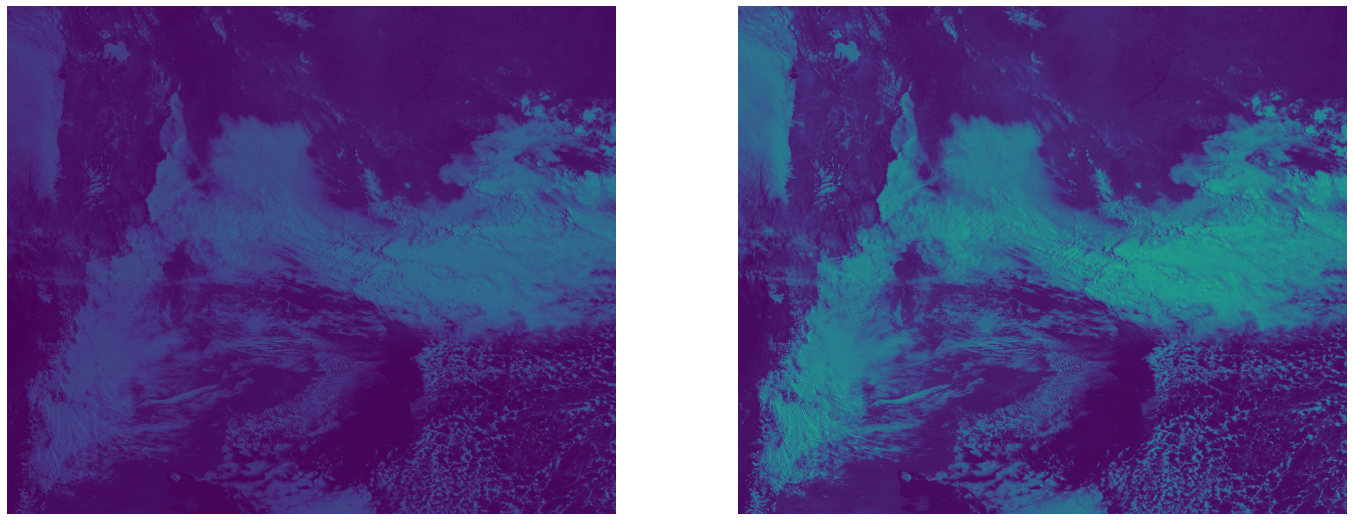

In [2]:
img_name = next(images_names)
hour = int(img_name.split('_')[2].replace('.FR', '')[:2])
rimg, rp_image, cosangs = load_img_modified(img_name=img_name)
# while np.any(cosangs < .15) == True or not(11 <= hour <= 13):
while img_name != 'ART_2020277_122019.FR':
    img_name = next(images_names)
    hour = int(img_name.split('_')[2].replace('.FR', '')[:2])
    rimg, rp_image, cosangs = load_img_modified(img_name=img_name)

vmax = max(np.max(rimg), np.max(rp_image))
print('hour: ', hour)
fig = plt.figure()
fig.set_size_inches(24, 12)

ax = fig.add_subplot(1, 2, 1)
ax.set_axis_off()
im = ax.imshow(rimg, vmin=0, vmax=vmax)
# plt.colorbar(im)
ax = fig.add_subplot(1, 2, 2)
ax.set_axis_off()
im = ax.imshow(rp_image, vmin=0, vmax=vmax)
# plt.colorbar(im)
plt.show()

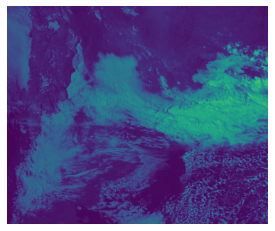

In [3]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_off()
plt.imshow(rimg)
fig.tight_layout()
fig.savefig('/home/franco/facultad/proyecto/deepCloud-latex-plots/images/outputs/rimage_not_normalized_example.png')
plt.close()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_off()
plt.imshow(rp_image)
fig.tight_layout()
fig.savefig('/home/franco/facultad/proyecto/deepCloud-latex-plots/images/outputs/rp_image_normalized_example.png')
plt.close()


In [19]:
import numpy as np

arr = np.array([.16, .5, 0.505])
np.all(arr > .15)

True